# TRƯỜNG ĐẠI HỌC SƯ PHẠM KỸ THUẬT TP. HCM
## KHOA CÔNG NGHỆ THÔNG TIN
### BỘ MÔN KỸ THUẬT DỮ LIỆU
<br/>

# Đề tài:
# ỨNG DỤNG PHƯƠNG PHÁP THỐNG KÊ VÀ HỌC MÁY DỰ ĐOÁN GIÁ NÔNG SẢN

<br/>

<p>Họ và tên Sinh viên 1 : Huỳnh Hạo Nhị MSSV 1: 20133006 <p>
<br/>
Họ và tên Sinh viên 2 : Võ Hoài Thương MSSV 2: 20133012

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV

from statsmodels.tsa.api import VAR
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

# Dữ liệu

In [2]:
RICE_QUANTITY_URI = "https://raw.githubusercontent.com/thuongh2/FinalProject/main/data_final/Lua/gia_lua_xang.csv"

## VAR MODEL

Mô hình VAR (vector autoregressive models) được sử dụng cho chuỗi thời gian đa biến. Cấu trúc của nó là mỗi biến là một hàm tuyến tính của các lag của chính nó và các lag của các biến khác

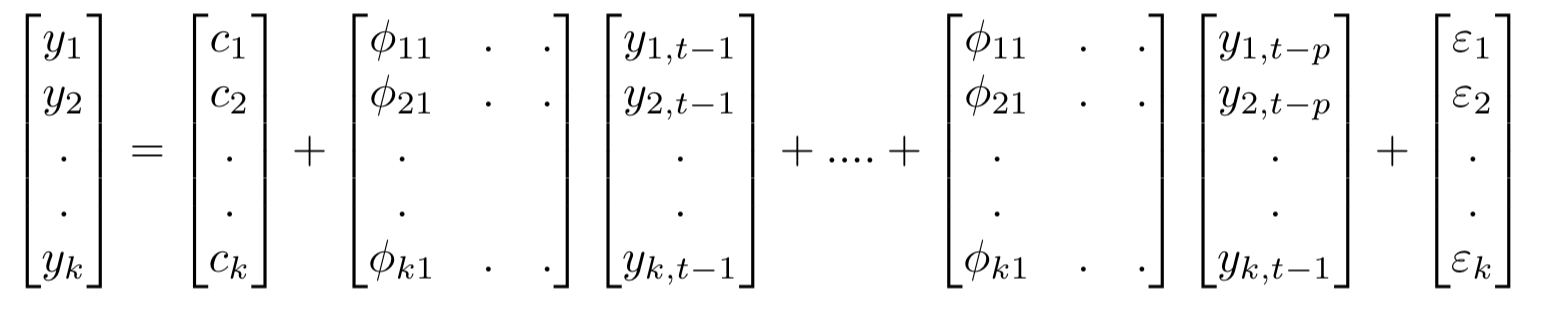

In [3]:
df = pd.read_csv(RICE_QUANTITY_URI)

In [4]:
df.set_index('date', inplace=True)

In [5]:
df.head()

,price,RON 95-III
date,,
2018-08-22,11000,21.17
2018-08-23,11000,21.17
2018-08-24,11000,21.17
2018-08-25,11000,21.17
2018-08-26,11000,21.17


<Axes: >

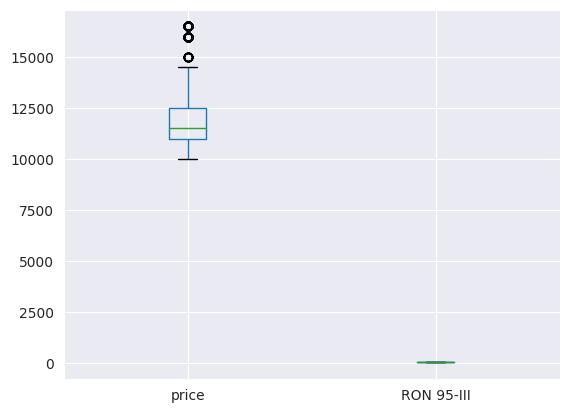

In [6]:
df.boxplot()

In [7]:
# Tính toán ngưỡng cho outlier sử dụng IQR
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Xác định các dòng dữ liệu có giá trị nằm ngoài ngưỡng
outliers = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]
print("Số lượng outlier:", len(outliers))

# Kiểm tra và thay đổi giá trị nếu nó nằm ngoài ngưỡng
df.at[df.index[0], 'price'] = min(max(df.iloc[0]['price'], lower_bound), upper_bound)

# Thay thế giá trị của outlier bằng giá trị trước đó
for index, row in outliers.iterrows():
    previous_date_index = df.index.get_loc(index) - 1
    if previous_date_index >= 0:
        previous_date = df.index[previous_date_index]
        previous_value = df.loc[previous_date, 'price']
        df.at[index, 'price'] = previous_value

Số lượng outlier: 210


<Axes: >

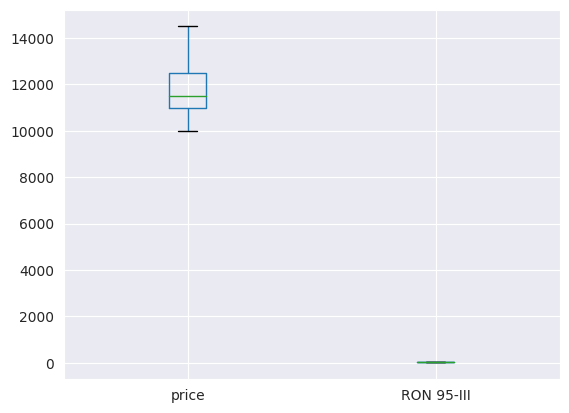

In [8]:
df.boxplot()

In [9]:
df = df.dropna()

In [10]:
# Find the pearson correlations matrix
corr = df.corr(method = 'pearson')
corr

,price,RON 95-III
price,1.000000,0.500863
RON 95-III,0.500863,1.000000


In [11]:
fillter_feature = ['price', 'RON 95-III']
df = df[fillter_feature]

In [12]:
# Find the pearson correlations matrix
corr = df.corr(method = 'pearson')
corr

,price,RON 95-III
price,1.000000,0.500863
RON 95-III,0.500863,1.000000


In [13]:
from google.colab import files
df.to_csv('./gia_lua_xang.csv')
files.download('./gia_lua_xang.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Axes: xlabel='date'>

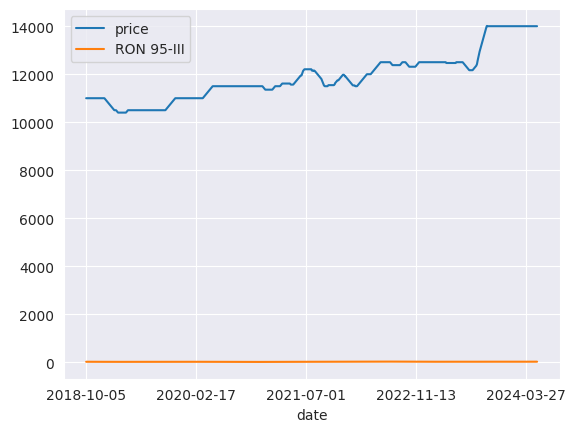

In [14]:
df = df.rolling(45).mean()
df = df.dropna()
df.plot()

In [15]:
nobs = int(len(df) * 0.8)
df_train, df_test = df[0:nobs], df[nobs:]

# Check size
print(df_train.shape)
print(df_test.shape)

(1640, 2)
(410, 2)


In [16]:
from google.colab import files


## Kiểm tra stationary

In [17]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [18]:
for name, column in df_train.items():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.9917
 No. Lags Chosen       = 6
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.7563. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "RON 95-III" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.3757
 No. Lags Chosen       = 22
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.5939. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.




In [19]:
df_differenced = df_train.diff().dropna()

In [20]:
for name, column in df_differenced.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.1736
 No. Lags Chosen       = 5
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "RON 95-III" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.3813
 No. Lags Chosen       = 21
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




## Train model

In [21]:
model = VAR(df_differenced)
for i in range(1, 50):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -8.452340595122573
BIC :  -8.432555865216298
FPE :  0.00021340034830440516
HQIC:  -8.445002526452594 

Lag Order = 2
AIC :  -8.449740327742127
BIC :  -8.416749365143646
FPE :  0.00021395597471258085
HQIC:  -8.437503750362763 

Lag Order = 3
AIC :  -8.446012006796487
BIC :  -8.399801656405119
FPE :  0.00021475517440956558
HQIC:  -8.428871740282583 

Lag Order = 4
AIC :  -8.443198084081224
BIC :  -8.383755169402347
FPE :  0.00021536035530543633
HQIC:  -8.421148939344091 

Lag Order = 5
AIC :  -8.444259456620966
BIC :  -8.371570779718127
FPE :  0.00021513193866838198
HQIC:  -8.417296235888651 

Lag Order = 6
AIC :  -8.44184157721032
BIC :  -8.355893918657209
FPE :  0.00021565278845196262
HQIC:  -8.409959074007828 

Lag Order = 7
AIC :  -8.436659027469812
BIC :  -8.33743914630209
FPE :  0.0002167733994585246
HQIC:  -8.399852026599252 

Lag Order = 8
AIC :  -8.43366545506892
BIC :  -8.321160088735926
FPE :  0.0002174234017870008
HQIC:  -8.391928732589609 

Lag Order = 9

In [22]:
x = model.select_order(maxlags=50)
x.summary()

,AIC,BIC,FPE,HQIC
0,-2.852,-2.845,0.05772,-2.850
1,-8.417,-8.397*,0.0002211,-8.409
2,-8.415,-8.382,0.0002214,-8.403
3,-8.413,-8.365,0.0002220,-8.395
4,-8.411,-8.350,0.0002224,-8.389
5,-8.413,-8.339,0.0002219,-8.386
6,-8.412,-8.324,0.0002221,-8.380
7,-8.408,-8.307,0.0002230,-8.371
8,-8.406,-8.291,0.0002234,-8.364
9,-8.405,-8.276,0.0002238,-8.357


In [23]:
model_var = model.fit(47)
model_var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 20, Jun, 2024
Time:                     08:41:36
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -8.22684
Nobs:                     1592.00    HQIC:                  -8.62989
Log likelihood:           2731.07    FPE:                0.000140856
AIC:                     -8.86805    Det(Omega_mle):     0.000125439
--------------------------------------------------------------------
Results for equation price
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.057275         0.056015            1.022           0.307
L1.price               0.931711         0.025762           36.166           0.000
L1.RON 95-III          3.713298        10.916880        

In [24]:
def adjust(val, length= 6): return str(val).ljust(length)

In [25]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_var.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

price  : 2.0
RON 95-III : 2.0


In [26]:
# Get the lag order
lag_order = model_var.k_ar
print(lag_order)

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

47


array([[ 0.00000000e+00,  6.80000000e-02],
       [ 0.00000000e+00,  4.35555556e-02],
       [ 0.00000000e+00,  4.35555556e-02],
       [ 0.00000000e+00,  3.57777778e-02],
       [ 0.00000000e+00,  3.57777778e-02],
       [ 0.00000000e+00,  3.57777778e-02],
       [ 0.00000000e+00,  3.57777778e-02],
       [ 0.00000000e+00,  2.86666667e-02],
       [ 0.00000000e+00,  2.86666667e-02],
       [ 0.00000000e+00,  2.86666667e-02],
       [ 0.00000000e+00,  2.86666667e-02],
       [ 0.00000000e+00,  2.86666667e-02],
       [ 0.00000000e+00,  2.86666667e-02],
       [ 0.00000000e+00,  2.86666667e-02],
       [ 0.00000000e+00,  2.86666667e-02],
       [ 0.00000000e+00,  2.60000000e-02],
       [ 0.00000000e+00,  2.60000000e-02],
       [ 0.00000000e+00,  2.60000000e-02],
       [ 0.00000000e+00,  2.60000000e-02],
       [ 0.00000000e+00,  2.60000000e-02],
       [ 0.00000000e+00,  2.60000000e-02],
       [ 0.00000000e+00,  2.60000000e-02],
       [ 0.00000000e+00,  2.60000000e-02],
       [ 0.

In [27]:
import joblib
joblib.dump(model_var, 'var_gia_lua.joblib')

['var_gia_lua.joblib']

In [28]:
from google.colab import files
files.download('var_gia_lua.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
# Forecast
nobs = len(df_test)
fc = model_var.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,price_2d,RON 95-III_2d
date,,
2023-04-02,-0.121506,-0.016123
2023-04-03,-0.289186,-0.012262
2023-04-04,-0.946971,-0.012702
2023-04-05,-0.809834,-0.014123
2023-04-06,-1.046571,-0.015681
...,...,...
2024-05-11,0.972113,0.002767
2024-05-12,0.976301,0.002743
2024-05-13,0.960772,0.002737


In [30]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+ '_2d'].cumsum()
    return df_fc

In [31]:
df_results = invert_transformation(df_train, df_forecast, second_diff=False)
df_results.loc[:, ['price_forecast']]

,price_forecast
date,
2023-04-02,12466.545160
2023-04-03,12466.255974
2023-04-04,12465.309003
2023-04-05,12464.499169
2023-04-06,12463.452598
...,...
2024-05-11,12819.799134
2024-05-12,12820.775435
2024-05-13,12821.736207


### Đánh giá mô hình VAR

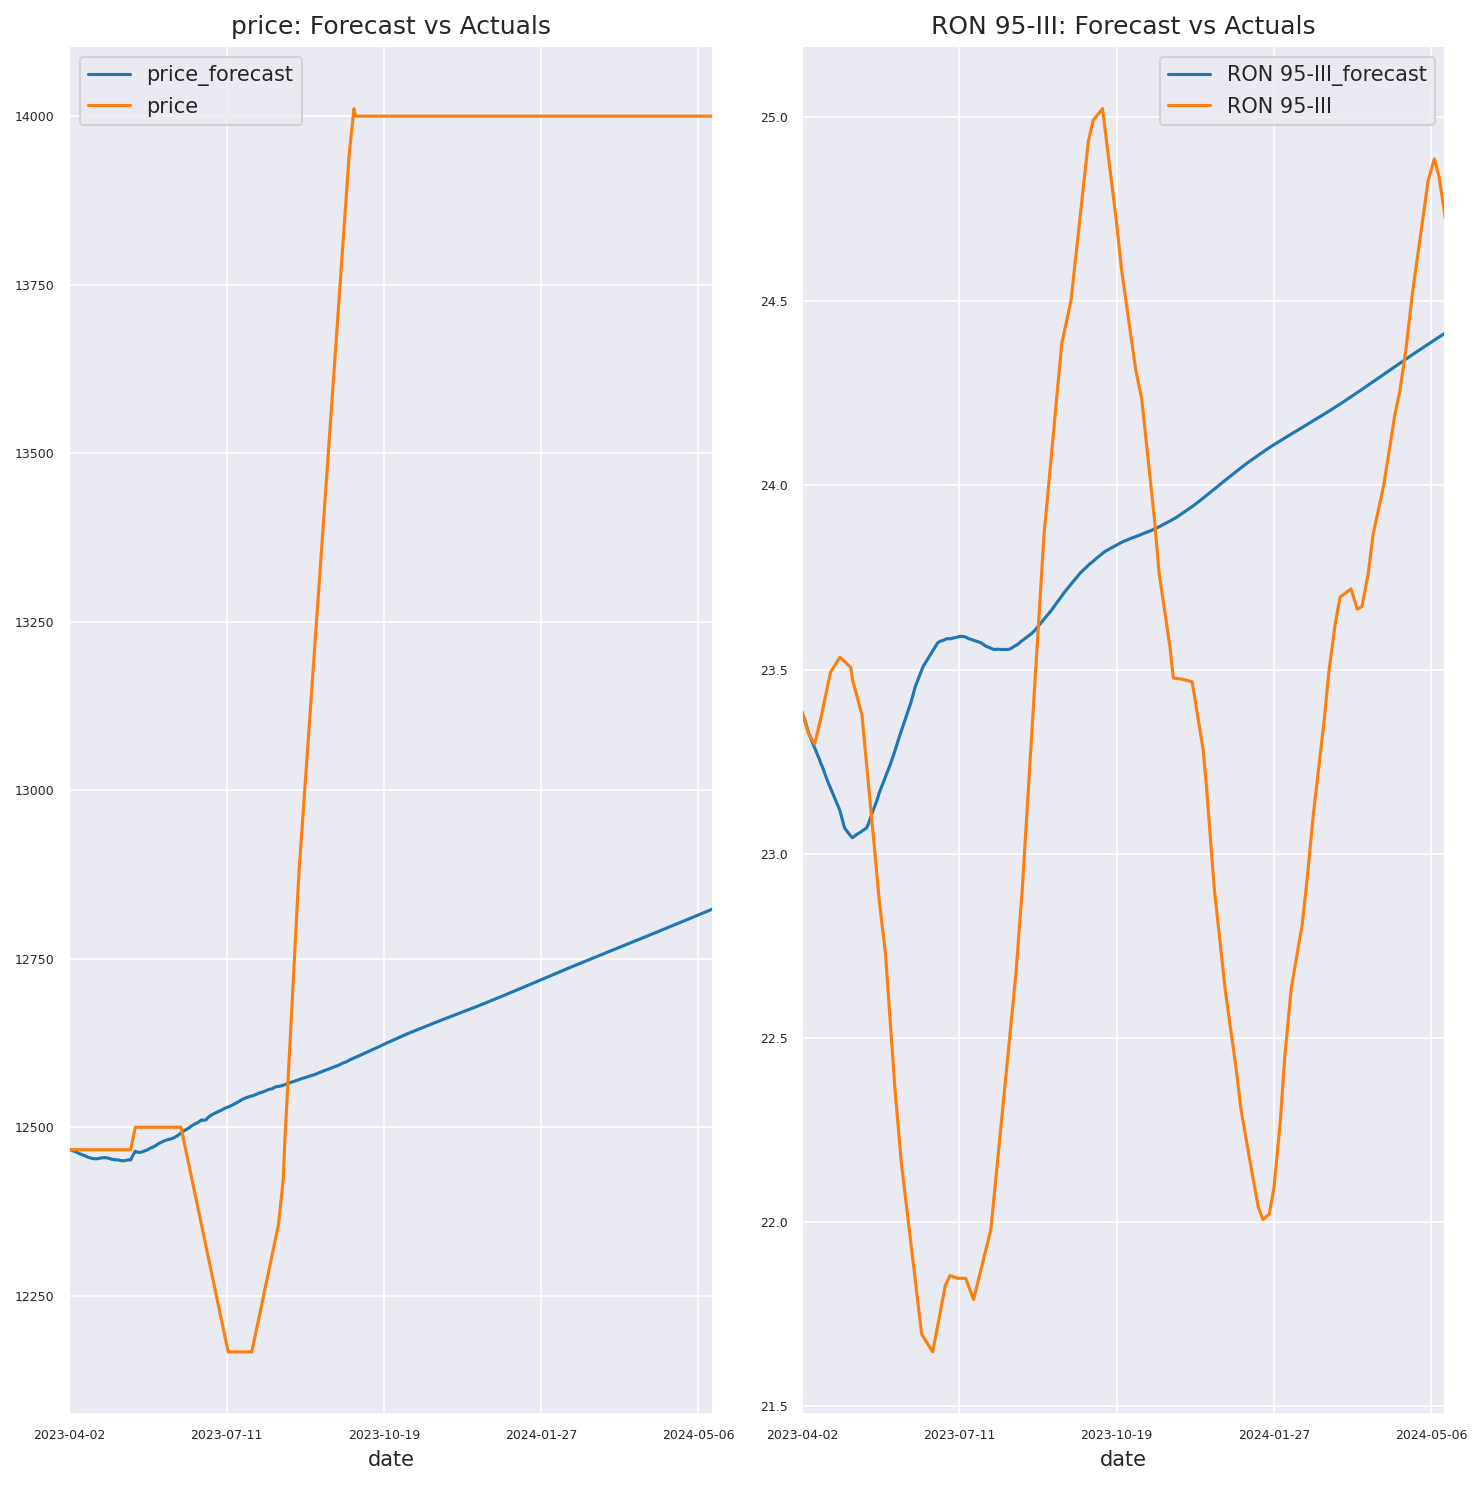

In [32]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [33]:
from sklearn.metrics import mean_absolute_percentage_error

def forecast_accuracy(forecast, actual):
    mape = mean_absolute_percentage_error(actual, forecast) * 100  # MAPE     # ME
    rmse = np.mean((forecast - actual)**2)**.5  # RMS
    return({'mape':mape, 'rmse':rmse})

In [34]:
print('Forecast Accuracy of: rgnp')
accuracy_prod = forecast_accuracy(df_results['price_forecast'].values, df_test['price'].values)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: rgnp
mape   :  6.044
rmse   :  1005.2034


## VARMA Model

Mô hình Vector Autoregressive Moving Average (VARMA) là sự kết hợp của mô hình VAR và mô hình VMA, giúp trong việc mô hình hóa chuỗi thời gian đa biến bằng cách xem xét cả thứ tự của lag và thứ tự của trung bình di chuyển (p và q) trong mô hình.

In [35]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.4 MB/s eta 0:00:00


In [36]:
from pmdarima import auto_arima

In [37]:
columns_train = fillter_feature

In [38]:
pq = []
for name, column in df_differenced[columns_train].items():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(df_differenced[name],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : price
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=7542.945, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=10931.236, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=7543.464, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=9461.190, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=7540.846, Time=1.09 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=7543.162, Time=0.30 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=7543.620, Time=0.99 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=7543.663, Time=1.81 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=7542.346, Time=1.19 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=7542.543, Time=1.14 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=9.62 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=7541.882, Time=4.29 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 21.166 seconds
optimal order for:price is: (2, 0, 1) 


Searching o

In [39]:
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn import metrics

In [40]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        df_res[str(col)+'_forecast'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

In [41]:
df_results_moni = pd.DataFrame(columns=['p', 'q','RMSE Open','RMSE High','RMSE Low','RMSE Close'])
print('Grid Search Started')
for i in pq:
    if i[0]== 0 and i[2] ==0:
        pass
    else:
        print(f' Running for {i}')
        model = VARMAX(df_differenced[columns_train], order=(i[0],i[2])).fit( disp=False)
        result = model.forecast(steps = 30)
        inv_res = inverse_diff(df_train[columns_train], result)
        Opensrmse = np.sqrt(metrics.mean_squared_error(df_test['price'][:30], inv_res['price_forecast']))

        print(({'p': i[0], 'q': i[2], 'RMSE Open':Opensrmse}))


Grid Search Started
 Running for (2, 0, 1)
{'p': 2, 'q': 1, 'RMSE Open': 3.4615436258607586}


In [42]:
# from above example we can see that p=1 , q=2, tr=n gives least RMSE
model_varma = VARMAX(df_differenced[columns_train], order=(4,4),trends = 'n').fit( disp=False)


In [43]:
result = model_varma.forecast(steps = len(df_test))

In [44]:
inv_res = inverse_diff(df_train[columns_train], result)

Đánh giá mô hình

In [45]:
accuracy_prod = forecast_accuracy(inv_res['price_forecast'].values, df_test['price'].values)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

mape   :  6.1423
rmse   :  1026.2293


In [46]:
df_test.index = pd.to_datetime(df_test.index)
df_train.index = pd.to_datetime(df_train.index)

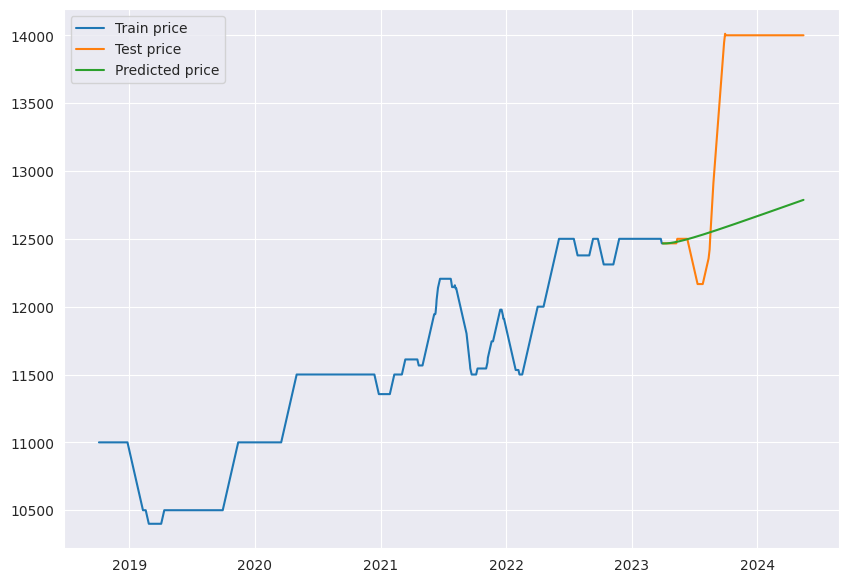

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in ['price']:

    plt.rcParams["figure.figsize"] = [10,7]
    plt.plot(df_train[str(i)], label='Train '+str(i))
    plt.plot(df_test[str(i)], label='Test '+str(i))
    plt.plot(inv_res[str(i)+'_forecast'], label='Predicted '+str(i))
    plt.legend(loc='best')
    plt.show()

In [48]:
import joblib
from google.colab import drive

drive.mount('/content/drive')

var_file_name = 'var_gia_lua_xang.joblib'
varma_file_name = 'varma_gia_lua_xang.joblib'

joblib.dump(model_varma, '/content/drive/MyDrive/model/' + varma_file_name)


joblib.dump(model_var, '/content/drive/MyDrive/model/' + var_file_name)

Mounted at /content/drive


['/content/drive/MyDrive/model/var_gia_lua_xang.joblib']